### OBS THIS NOTEBOOK IS AN PDF CREATED OF THE JUPITER NOTEBOOK, BECAUSE GITHUB WONT LOAD IT CORRECTLY

# This notebook will show how I’ve created a script which can search for venues in Copenhagen of a certain type and convert the results into a DataFrame, use k-means clustering, using the elbow method for determining the best number of k's, and lastly show the results on a folium map, with population numbers plotted as well


### First the necessary libraries will be imported

In [1]:
# import the nescesary libraries


import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from pandas.io.json import json_normalize

# Import the nessecary libraries for clustering and mapmaking

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline  

# import cdist, and pdist to calculate distance from centrooid for the elbow method
from scipy.spatial.distance import cdist, pdist

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Import the geopandas module for handling gejsons
import geopandas as gpd

In [2]:
#install and import folium for map rendering


#!conda install -c conda-forge folium=0.5.0 --yes 
import folium

# Three folium maps will be created for later use. One for checking if the coordinates obtained from official data sources, cover Copenhagen in a satisfactory way for use in foursquare and function, and two  plotting the data

In [3]:
# Coordinates for Copenhagen from https://www.latlong.net/place/copenhagen-denmark-4775.html

lat_co = 55.676098
long_co = 12.568337

# create two instances of the copenhagen map

# For checking dispersion of coordinates
map_co = folium.Map(location=[lat_co, long_co], zoom_start=11.5)

# For plotting clusters on map with boroughs
map_co1 = folium.Map(location=[lat_co, long_co], zoom_start=11.5)

# Get official geojson for burough limits
geo_j= r'http://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:bydel&outputFormat=json&SRSNAME=EPSG:4326'

# Add to map
folium.GeoJson(geo_j).add_to(map_co1)

# for choropleth map
map_co2 = folium.Map(location=[lat_co, long_co], zoom_start=11.5)

# In this section the population data and coordinates for administrative units "roder", will be collected

In [4]:

# obtain csv file with administrative units (roder) and population stats
url1 = 'https://data.kk.dk/dataset/dfbe2720-1c0d-4dee-8f48-2ae1f25091b0/resource/e287642f-c16c-4fcd-ab86-9053ad0521c0/download/befolkningkbh.csv'

pop = pd.read_csv(url1)

# Explore data

pop.info()
pop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514438 entries, 0 to 1514437
Data columns (total 5 columns):
AAR         1514438 non-null int64
RODE        1514438 non-null int64
KOEN        1514438 non-null int64
ALDER       1514438 non-null int64
PERSONER    1514438 non-null int64
dtypes: int64(5)
memory usage: 57.8 MB


AAR  RODE  KOEN  ALDER  PERSONER
0  2015     1     1      0         6
1  2015     1     1      1         6
2  2015     1     1      3         3
3  2015     1     1      4         4
4  2015     1     1      5         3

In [5]:
# Clean dataframe

# Remove columns with age and gender 

pop.drop(['KOEN', 'ALDER'], axis=1, inplace=True)

# chosse only the year 2015

pop = pop[pop.AAR == 2015]

# Sum up the persons living in each administrative unit

pop = pop.groupby(['RODE'])['PERSONER'].sum()

pop = pd.DataFrame(pop).reset_index()

# rename columns so they are the same as the geojson in the next code field
pop.columns = ['rode_nr', 'Personer']

# Examine min and max values for later use in folium map with population stat (threshold_scale)

#print('Max value', pop['Personer'].max())
#print('Min value', pop['Personer'].min())


### After making the DataFrame with population data, it will be merged with geojson file with administrative units

In [6]:
# geojson with administravie units "roder"

js_roder = r'http://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:rode&outputFormat=json&SRSNAME=EPSG:4326'


# Use geopnadas to read in geojason with administrative units
file = gpd.read_file(js_roder)

# Drop unnecessary columns
#oder = file['rodenavn']

file.drop(['rodenavn', 'distrikt_nr', 'areal_m2', 'id', 'bydel'], axis=1, inplace=True)

# merge with popdataframe

df_roder = file.merge(pop, how='left', left_on='rode_nr', right_on='rode_nr')

# replace NaN with 0 så it can be used in a choropleth later on

df_roder.fillna(0, inplace=True)

# Save as geojson

df_roder.to_file("roder.geojson", driver='GeoJSON')

df_roder.head()

rode_nr                                           geometry  Personer
0       17  (POLYGON ((12.5826025317837 55.67674174792494,...       0.0
1      107  (POLYGON ((12.56159677231597 55.69635404179332...     303.0
2      164  (POLYGON ((12.54193932257353 55.70658806248724...    4586.0
3        2  (POLYGON ((12.56625392688763 55.67856006861916...     698.0
4        3  (POLYGON ((12.5684420463914 55.67670315220757,...     385.0

### Next the coordinates will be extracted from df_roder 

In [7]:
# load df_roder in a new dataframe containing only coordinates

p = df_roder['geometry']

# Convert to string for parsing the coordinates and create for loop to extract coordinates, convert to float
# and make DataFrame coor


lat_p = []
lng_p = []
p = p.astype(str)

temp_lat = []
temp_lng = []


for i in p:
    temp_lng.append(i[16:30])
    temp_lat.append(i[33:48])    
    
for i in temp_lng:
    i = i[0:10]
    i = float(i)
    lng_p.append(i) 


for i in temp_lat:
    if i.startswith('55.'):
        i = i[0:-1]
        i = float(i)
        lat_p.append(i)
    elif i.startswith(' 55'):
        i =  i[1:]
        i = float(i)
        lat_p.append(i)
    elif i.startswith('5.'):
        i = '5' + i[0:-2]
        i = float(i)
        lat_p.append(i)
        
        
coor = pd.DataFrame(list(zip(lat_p, lng_p)), 
               columns =['lat', 'lng'])

coor.head()

lat        lng
0  55.676742  12.582603
1  55.696354  12.561597
2  55.706588  12.541939
3  55.678560  12.566254
4  55.676703  12.568442

In [8]:
# Use folium to check if the coordinates in coor covers Copenhagen well

for lat, lon in zip(coor['lat'], coor['lng']):
    folium.CircleMarker(
        radius=8,
        location=[lat, lon],
        color='purple',
        fill=False,
        fill_opacity=0.7).add_to(map_co)
map_co

# Now the data will be collected thru forusqare api

In [9]:
CLIENT_ID = 'C4TKHUWCRCSH1NYV0LBALUUI5XTUQKNGA0QYZOFT3G3ADJEY' 
CLIENT_SECRET = 'SRW34K0JP4SR1ZLMM3DPLPY5JW45ASSHH25CJZVQLGMX4VEE'
VERSION = '20180605'
LIMIT = 100

# Create input for venue search for the api

search_query = str(input('Enter kind of venue : '))

Enter kind of venue : cafe


In [10]:
# Make function to to search the coordinates collected in DataFrame coor sonsicting of a 
#forloop to get all the venues near each coordinate.

def getNear(latitudes, longitudes, radius=1000):
    
    lst_navn = []
    lst_lat = []
    lst_lng = []
    
    for lat, lng in zip(latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&intent=browse&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION,
        lat, 
        lng,
        search_query,
        radius, 
        LIMIT)
        
        results = requests.get(url).json()['response']
        
        
        for i in results['venues']:
            lst_navn.append(i['name'])
            lst_lat.append(i['location']['lat'])
            lst_lng.append(i['location']['lng'])
        
        
    # Create DataFrame from the resulting lists 
    
    df = pd.DataFrame(list(zip(lst_navn, lst_lat, lst_lng)), 
               columns =['Name', 'lat', 'lng'])
    return(df)
    

In [10]:
# Uae getNear function on coor to grab the venues 

cop_ven = getNear(latitudes=coor['lat'], longitudes=coor['lng'])


In [ ]:
# Save the dataframe so the results can be used severeal timers, witwout making a call to the api each time

cop_ven.to_pickle('prove')

In [11]:
# examine the results, it’s clear that there are way too many results, because a lot of the coordinates a close to each other, 
# there will be a lot of duplicates of the venues

# read prove
df1 = pd.read_pickle('prove')
print(df1.head())
print(df1.tail())

                        Name        lat        lng
0  Hard Rock Cafe Copenhagen  55.676662  12.569049
1           Cafe Europa 1989  55.678688  12.579640
2          Hoppes Cafe & Bar  55.678104  12.578107
3              Cafe Langebro  55.669178  12.580327
4            Café Oven Vande  55.673280  12.592783
                          Name        lat        lng
11664   Ocak Café-sandwich hus  55.670298  12.537865
11665      Ban Ton Food & Cafe  55.671782  12.552334
11666                Café Exit  55.671899  12.551520
11667                Cafe Wood  55.672190  12.548773
11668  Føtex Cafe, fisketorvet  55.661628  12.559630


In [12]:
# Sort the DataFrame on name as to examine if there are any duplicates, and for dropping of duplicates later on

df1.sort_values("Name", inplace = True) 

df1.head()

Name        lat        lng
2121   13Z Café  55.664292  12.622599
10632  13Z Café  55.664292  12.622599
1355   13Z Café  55.664292  12.622599
9513   13Z Café  55.664292  12.622599
2940   13Z Café  55.664292  12.622599

In [13]:
# Drop duplicates

df1.drop_duplicates(subset ="Name", 
                     keep = 'first', inplace = True)


df1.reset_index(inplace=True)
df1.drop(['index'], axis=1, inplace=True)

df1.head()

Name        lat        lng
0                          13Z Café  55.664292  12.622599
1                    3'erens IsCafe  55.654568  12.649390
2  Aliva Foods Concept Store & Cafe  55.703021  12.584680
3                    Allehånde Café  55.647969  12.649141
4                       Almasa Cafe  55.661127  12.604182

# Usig KMeans and elbow method to cluster results

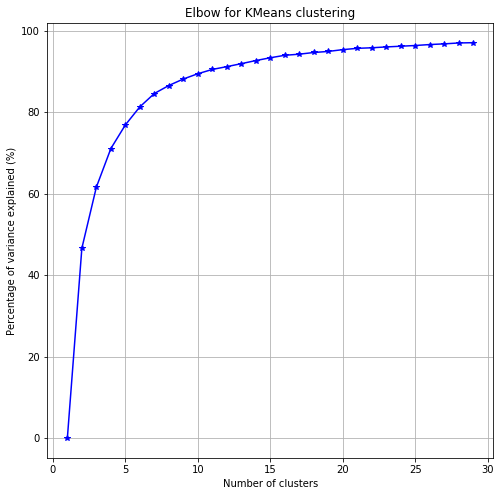

In [14]:
# make an function to calculate best number of k's via the elbow method, and plot it


Ks = range(1, 30)
k = df1[['lat','lng']]
kmean = [KMeans(n_clusters=i).fit(k) for i in Ks]

def plot_elbow(kmean, k):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(k, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(k)**2)/k.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, k)

In [15]:
# Run KMeans on the results 

klusters = 10

co_gr = df1.drop('Name', 1)

kmeans = KMeans(n_clusters=klusters, random_state=0).fit(co_gr)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([1, 1, 2, 1, 1, 1, 8, 4, 4, 8])

In [16]:
# insert cluster labels

co_merged = df1

co_merged.insert(0, 'Cluster Labels', kmeans.labels_)



# Pot the results on copenhagen map with buroughs

In [17]:


x = np.arange(klusters)
ys = [i + x + (i*x)**2 for i in range(klusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(co_merged['lat'], co_merged['lng'], co_merged['Name'], co_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_co1)
    


In [18]:
map_co1

### Create choropleth map with population in "roder"

In [19]:
map_co2.choropleth(geo_data="roder.geojson" , data=df_roder,
    columns=['rode_nr', 'Personer'],
    key_on='feature.properties.rode_nr',
    threshold_scale=[0,300, 1000, 2000, 3000, 5300],
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of residents in an area, where data is not available color = beige')


C:\Users\the_u\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [20]:
map_co2

In [21]:
# Plot the clusters on the map

x = np.arange(klusters)
ys = [i + x + (i*x)**2 for i in range(klusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(co_merged['lat'], co_merged['lng'], co_merged['Name'], co_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_co2)


In [22]:
map_co2    